# Support Vector Machines: Programming Practice

COSC 410: Applied Machine Learning\
Colgate University\
*Prof. Apthorpe*

## Overview

This notebook will give you practice with the following topics:
  1. Training linear and non-linear SVM models 
  2. Choosing SVM kernels
  3. Tuning hyperparameter C
  4. One-versus-rest and one-versus-one approaches to multiclass SVM
  5. Visualizing SVM decision boundaries
  
  
We will be using the MNIST handwritten digits dataset available directly from Scikit-Learn. Like the Iris dataset, MNIST is a classic starting dataset for machine machine learning novices. MNIST is often used as a preliminary test for new machine learning models, and this class would be lacking if you weren't expected to try an MNIST classification at some point. 

The dataset itself consists of 8x8-pixel images of handwritten numbers. The goal is to predict what number the person intended to write from the image. This is a specific instance of a problem called "optical character recognition" (OCR) -- understanding printed characters, words, and numbers from images. OCR is a big business. Any company that requires automatic processing of handwritten forms relies on OCR. You have probably used OCR yourself, perhaps in an app that scans a restaurant receipt and divides a check or translates words in camera footage on the fly.

While the MNIST classification task is classic, it is not trivial. The images below show 4 of the labeled images. As discussed in class, humans are *very good* at this type of visual classification task, with a test set accuracy of ~98%. The best ML algorithms have >99% accuracy, but we today we will settle for trying to beat human performance with our SVM.

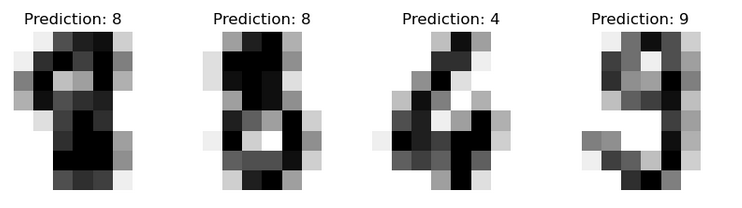

## Part 1. Data Preprocessing

First, import the necessary libraries

In [1]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn import datasets, model_selection, preprocessing, svm, metrics, decomposition
np.random.seed(0) # set random seed so everyone gets same results

Next, load the data and split it into features and labels

In [2]:
digits = datasets.load_digits()
X = digits.images
y = digits.target

As always, we should check the shape of the data

In [4]:
# Print the shape of X and y
print(X.shape)
print(y.shape)
# Print the number of examples in each class using the numpy unique() function
print(np.unique(y, return_counts=True))

(1797, 8, 8)
(1797,)
(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]), array([178, 182, 177, 183, 181, 182, 181, 179, 174, 180], dtype=int64))


This means that MNIST has 1797 images and each image is 8x8 pixels. The images are very nearly balanced accross classes (0-9), meaning that accuracy is a fine metric to use for this classification problem. However, we can't directly plug a 3D matrix into our SVM, because it expects that each example will have a feature *vector* not a feature *matrix*. We will therefore `reshape` the images into vectors.

In [5]:
# Use the numpy reshape() function to flatten the 8x8 images into 1x64 example vectors and reassign the result to X
X = X.reshape(len(X), -1)

Check the shapes again for sanity

In [6]:
# Print the shape of X
print(X.shape)

(1797, 64)


Perfect -- We now have a (# examples by # features) matrix. The images below visualize what this reshaping step does to the data

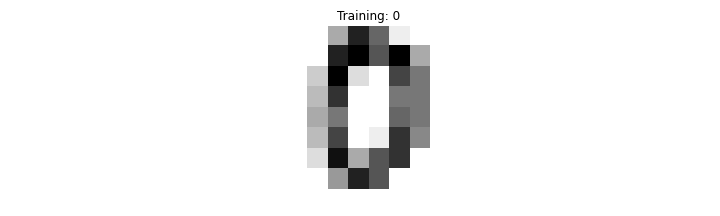

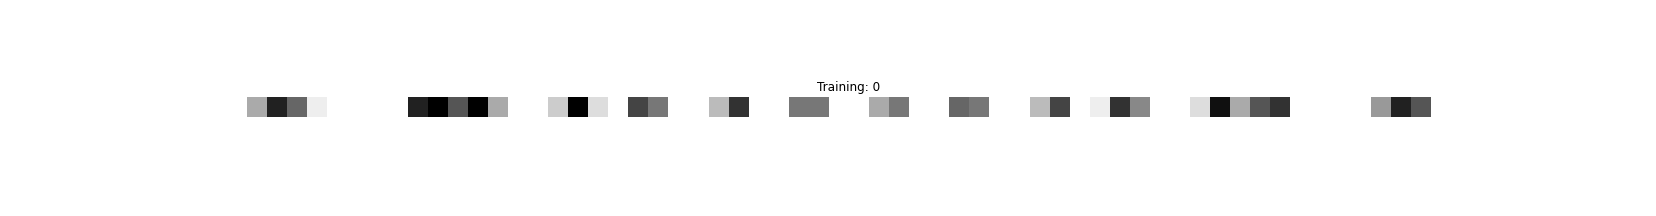

Now we need to divide the data into *train* and *test* sets and then standardize the data based on the training set. *Standardization is very important for SVMs*.

In [8]:
# Split the data into 80%/20% train/test using the train_test_split functions
X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y, test_size = 0.2, shuffle = True)

In [9]:
# Standardize the data based on the training set
ss = preprocessing.StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

Data preprocessing complete...let's get to the SVMs!

## Part 2. Training SVMs

Before diving in, it's worthwhile to enumerate all of the model selection and training options you want to consider. This helps you be systematic about finding the best option for your data. Just focusing on the SVM topics from class today, here's what we have:

**Multiclass**
 1. One-vs-one
 2. One-vs-rest
 
**SVM models**
 1. Linear SVM
 2. Kernel SVM
     * Polynomial kernel
     * Radial basis function kernel
     * Sigmoid kernel

**SVM hyperparameters**
 1. Margin violation weight C
 
This is a lot to test, but fortunately the MNIST data is relatively small, so we can do a "grid search" trying all combinations of these options. We will use the Scikit-Learn `SVC` class to perform our SVM training and prediction: https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html
     

In [14]:
# Keyword arguments for options above
multiclass = ["ovo", "ovr"]
kernel = ["linear", "poly", "rbf", "sigmoid"] # if kernel is "polynomial", we'll use the default degree of 3 (cubic)
cs = [1, 10, 100, 1000]

# Create an empty Pandas dataframe to store the results
results = pd.DataFrame()

# Loop over all combinations of the SVC options using the itertools.product() function
for m, k, c in itertools.product(multiclass, kernel, cs):
    
    # create model
    svc = svm.SVC(C=c, kernel=k, decision_function_shape=m)
    
    # Train model and compute average 5-fold cross-validation accuracy
    accuracies = model_selection.cross_val_score(svc, X_train, y_train)

    # Concatenate accuracy results to storage dataframe
    results = pd.concat([results, pd.DataFrame([[m,k,c, accuracies.mean()]], columns=["multiclass", "kernel", "c", "Accuracy"])], ignore_index=True)

# Sort results by accuracy and display
print(results.sort_values(by="Accuracy", ascending = False))

   multiclass   kernel     c  Accuracy
5         ovo     poly    10  0.988860
21        ovr     poly    10  0.988860
22        ovr     poly   100  0.988163
6         ovo     poly   100  0.988163
7         ovo     poly  1000  0.988163
23        ovr     poly  1000  0.988163
8         ovo      rbf     1  0.981901
24        ovr      rbf     1  0.981901
27        ovr      rbf  1000  0.981204
26        ovr      rbf   100  0.981204
25        ovr      rbf    10  0.981204
9         ovo      rbf    10  0.981204
10        ovo      rbf   100  0.981204
11        ovo      rbf  1000  0.981204
0         ovo   linear     1  0.974260
18        ovr   linear   100  0.974260
19        ovr   linear  1000  0.974260
16        ovr   linear     1  0.974260
17        ovr   linear    10  0.974260
1         ovo   linear    10  0.974260
3         ovo   linear  1000  0.974260
2         ovo   linear   100  0.974260
12        ovo  sigmoid     1  0.950600
28        ovr  sigmoid     1  0.950600
20        ovr     poly   

This tells us that the best choice of kernel is clearly `polynomial`, the choice of one-vs-one or one-vs-rest doesn't matter, and a choice of `c >= 10` is good. 

Let's retrain this model with our chosen options on the full training dataset and try a test set prediction. We'll use one-vs-rest bceause it is more computationally efficient.

In [ ]:
# Create SVC with optimal hyperparameters found from the grid search above


# Fit the SVC on the full training data


# Predict labels for the test data


# Compute and print the test accuracy


With these options, we get a test set classification accuracy >98% --> As good or better than a human!  Let's also plot a confusion matrix to see where the (very few) errors are happening:

In [ ]:
# Plot confusion matrix using the ConfusionMatrixDisplay.from_estimator() function 


## Part 3. Visualizing SVMs

Now that we've found a good SVM model for the MNIST data, lets try to visualize how it works. The MNIST examples have 64 dimensions (hard to visualize!) so we will use PCA to project them onto 2D. We will also plot individual one-vs-rest results. 

In [ ]:
# Project the MNIST data onto two dimensions via PCA. Use the same transformation from the training data for the test data

# Print shape of resulting data to confirm it is indeed 2D


We'll arbitrarily start with the **7 vs. rest** classifier. Let's look at how the images of handwritten 7s cluster in this new 2D space

In [ ]:
# Create a new list of training labels corresponding to "7" or "not-7"


# Plot all PCA-projected MNIST points with points corresponding to 7s colored differently


Well this definitely isn't linearly separable, but it does cluster pretty well, so lets try training a non-linear SVM and plotting the decision line



In [ ]:
# Create a SVC with a polynomial kernel and train it to predict 7 or not-7


# Functions below from https://stackoverflow.com/questions/51297423/plot-scikit-learn-sklearn-svm-decision-boundary-surface
def make_meshgrid(x, y, h=.02):
    x_min, x_max = x.min() - 1, x.max() + 1
    y_min, y_max = y.min() - 1, y.max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

# Plot the decision boundary of the 7-vs-rest SVC
fig, ax = plt.subplots(figsize=(11,11))
xx, yy = make_meshgrid(X_train_2d[:,0], X_train_2d[:,1])
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y7, cmap=plt.cm.coolwarm, s=30, edgecolors="k")
plt.show()

Not great...Let's try it with an RBF kernel instead:

In [ ]:
# Create a SVC with a rbf kernel and train it to predict 7 or not-7


# Plot the decision boundary of the 7-vs-rest SVC
fig, ax = plt.subplots(figsize=(11,11))
xx, yy = make_meshgrid(X_train_2d[:,0], X_train_2d[:,1])
plot_contours(ax, clf, xx, yy, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(X_train_2d[:,0], X_train_2d[:,1], c=y7, cmap=plt.cm.coolwarm, s=30, edgecolors="k")
plt.show()

That seems better! But the post-PCA classification accuracy is still terrible:

In [ ]:
# Create a one-versus-rest SVC with a rbf kernel and train it on the full PCA-projected 2D MNIST data


# Predict the labels of the PCA-projected 2D MNIST test set


# Compute and print the test accuracy


**TAKEAWAY:** Dramatic dimensionality reduction (i.e. to 2D or 3D) may enable visualization, but it typically reduces classification accuracy. Better to keep your data in the original dimensions unless you believe some reatures really are irrelevant to the task or there are too many features for computationally feasible training.

## *(Optional)* Part 4. Try It Yourself

Train a SVM on the `energydata.csv` dataset to predict whether local weather conditions will place a household in the **top 50%** or **bottom 50%** of energy consumers. You will need to
1. Convert the `Appliances` column (energy consumption) into binary based on the 50% threshold and use this column as your labels
2. Try multiple kernels and values of C to find hyperparameters that produce the best generalizable model (test using cross-validation)
3. Print the final accuracy on a test set that you did *NOT* use for setting hyperparamters